In [6]:
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import time

Global Parameters

In [7]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3
nRockets = 1000

# Global Simulation Parameters
tmax = 100
L = 100
binS = 100
zi = 127
dx = L / binS
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

In [8]:
# Cluster dirs
# homeDir = "/cluster/tufts/hertzberglab/nshah14/"
# sharedDir = "/cluster/tufts/hertzberglab/shared/Rockets/"
# simName = "Sim_100v"
# simDir = sharedDir + simName + "/"

homeDir = "C:\\Users\\NeilShah\\Documents\\PhD\\Rocket Capture\\"
simName = "Sim_100v"
simDir = homeDir + simName + "\\"

[50.49446064 50.43313706 50.55428103]


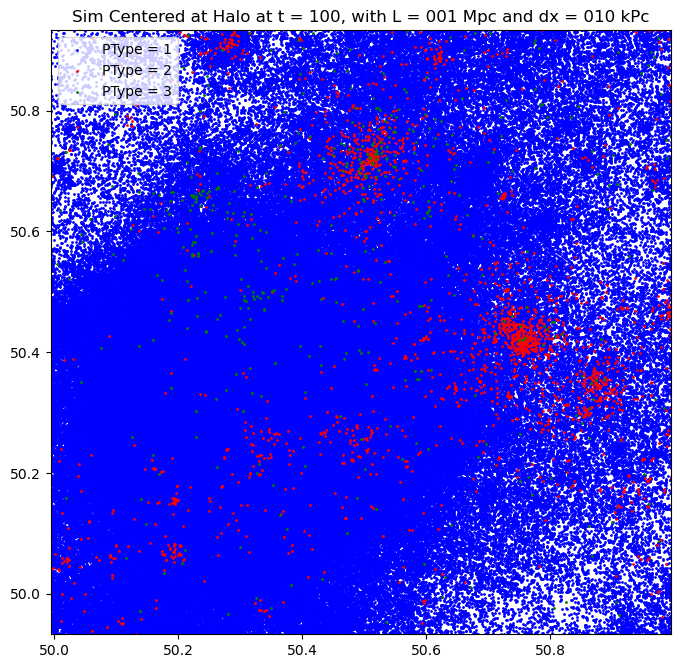

In [23]:
t = 100
L = 1
dx = 0.01
override = True

snapDir = simDir + "snapdir_{:03d}/".format(t)
pathArr = np.asarray(os.listdir(snapDir))

saveDir = simDir + simName + "_rhoXZoom__L_{:03d}Mpc__dx_{:03d}kPc".format(L, int(1000 * dx))
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
savePath = saveDir + "rhoXZoom__L_{:03d}Mpc__dx_{:03d}kPc__t_{:03d}.npy".format(L, int(1000 * dx), t)

fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = fig.gca()
mcolors = np.asarray(["Blue", "Red", "Green"])

if os.path.exists(savePath) and not override:
    rhoxZoom = np.load(savePath)
else:
    ptypeN = 3
    massArr = getMass()
    haloC = getHaloC(tmax)
    print(haloC)
    binS = int(L / dx)
    rhoxZoom = np.zeros((binS, binS, binS))
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        mi = massArr[pi]
        coordsi = np.empty((0, 3), dtype=float)

        for pathi in np.arange(0, pathArr.size):
            datGet = "/PartType{:d}/Coordinates".format(ptype)
            try:
                coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
                coordsi = np.concatenate([coordsi, coords], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass

            for ci, coord in enumerate(coords):
                i, j, k = list(map(int, np.floor((coord - haloC + L/2) / dx)))
                if i < 0 or i > binS - 1 or j < 0 or j > binS - 1 or k < 0 or k > binS - 1:
                    # print("coord = {} , ijk = {}".format(coord, [i, j, k]))
                    continue
                try:
                    rhoxZoom[i, j, k] += mi
                except IndexError:
                    print("Indexing Error! i, j, k = {}".format([i, j, k]))
                    time.sleep(1)
        plt.scatter(coordsi[:,  0], coordsi[:,  1], c=mcolors[pi], s=1, label="PType = {}".format(ptype))
    rhoxZoom *= rhoScale * 1e10
    np.save(savePath, rhoxZoom)

plt.xlim([haloC[0] - L/2, haloC[0] + L/2])
plt.ylim([haloC[1] - L/2, haloC[1] + L/2])
plt.title("Sim Centered at Halo at t = {:03d}, with L = {:03d} Mpc and dx = {:03d} kPc".format(t, L, int(1000 * dx)))
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

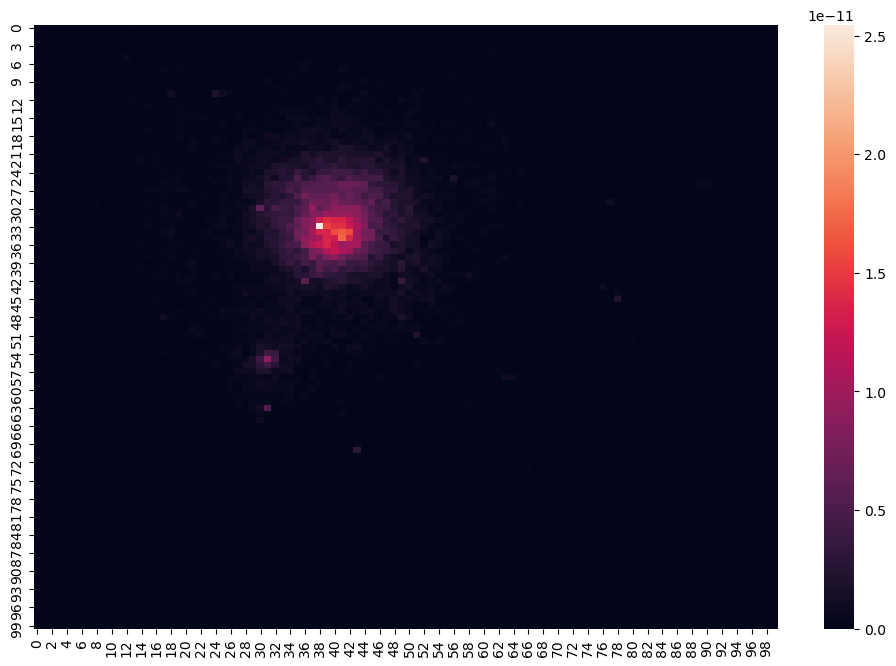

In [28]:
plt.figure(2, figsize=(12, 8), dpi=100)
sns.heatmap(rhoxZoom[:, :, 50])
# plt.imshow(rhoxZoom[:, :, 50], cmap='hot', interpolation='nearest')
# plt.show()

In [14]:
def getMass():
    tFix = 50
    massTab = np.zeros(3)

    snapDir = simDir + "snapdir_{:03d}/".format(tFix)
    path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
    fil = h5py.File(path1, 'r')

    ptypeN = 3
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        datGet = "/PartType{:d}/Masses".format(ptype)
        massTab[pi] = np.asarray(fil[datGet])[0]

    return massTab

In [11]:
def getHaloC(t):
    haloFinalDir = simDir + "snapdir_{:03d}/".format(t)
    pathArr = np.asarray(os.listdir(haloFinalDir))
    haloFinalCoords = np.empty((0, 3))

    for pathi in np.arange(0, pathArr.size):
        datGet = "/PartType1/Coordinates"
        try:
            coords = np.asarray(h5py.File(haloFinalDir + pathArr[pathi], 'r')[datGet])
        except KeyError:
            continue
        haloFinalCoords = np.concatenate([haloFinalCoords, coords], axis=0)

    haloC = np.asarray([np.mean(haloFinalCoords[:, i]) for i in range(3)])
    return(haloC)